# QUEKO circuit generation

In [1]:
import networkx as nx
from queko import queko_circuit

## Example: 5-qubit hardware graph

In [2]:
G = nx.Graph()
G.add_nodes_from(list(range(5)))
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4)])

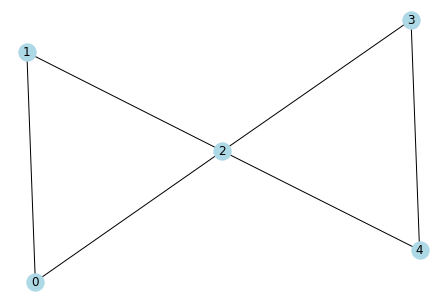

In [3]:
nx.draw(G, node_color='lightblue', with_labels=True)

Generate a QUEKO circuit with at most depth 10, and gate densities of 0.2 for single-qubit gates and 0.3 for two-qubit gates.

In [4]:
qasm_string, perm = queko_circuit(G, 10, [0.2, 0.3])

print(qasm_string)
print(perm)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
cx q[2] q[1];
x q[3];
x q[1];
cx q[2] q[1];
cx q[2] q[0];
x q[3];
x q[0];
x q[1];
x q[2];
cx q[1] q[0];
cx q[4] q[2];
x q[0];
x q[3];
cx q[1] q[0];
x q[4];
cx q[2] q[1];
cx q[3] q[2];
x q[0];

[4 3 2 1 0]


In [5]:
# Optionally we can change the type of gates
qasm_string, perm = queko_circuit(G, 10, [0.2, 0.3], gate_options={1: "h", 2: "cz"})
print(qasm_string)
print(perm)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
h q[0];
h q[4];
cz q[3] q[1];
cz q[4] q[0];
cz q[3] q[1];
h q[0];
cz q[3] q[2];
h q[0];
cz q[4] q[3];
h q[2];
h q[0];
h q[0];
cz q[0] q[3];
h q[1];
cz q[0] q[3];
cz q[1] q[2];
h q[0];
h q[0];

[4 0 3 1 2]


## Example: 5x5 lattice graph

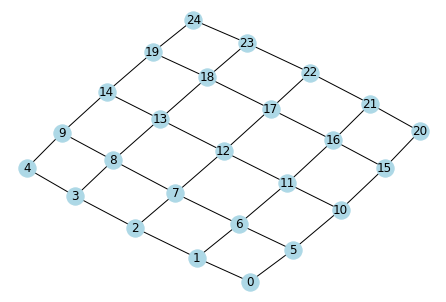

In [6]:
lattice_dim = 5

G = nx.grid_graph((lattice_dim, lattice_dim))

labels = {list(G.nodes)[node_idx] : str(node_idx) for node_idx in range(len(G.nodes))}
nx.draw(G, node_color='lightblue', labels=labels)

In [7]:
qasm_string, perm = queko_circuit(G, 10, [0.1, 0.3], lattice_dim=lattice_dim)
print(qasm_string)
print(perm)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[25];
cx q[24] q[22];
cx q[3] q[8];
cx q[20] q[11];
x q[22];
cx q[0] q[17];
cx q[9] q[4];
x q[20];
cx q[8] q[2];
cx q[24] q[22];
x q[18];
cx q[20] q[11];
cx q[6] q[0];
x q[13];
cx q[10] q[2];
cx q[22] q[9];
cx q[4] q[17];
x q[5];
cx q[7] q[8];
cx q[11] q[15];
cx q[1] q[12];
cx q[22] q[6];
cx q[23] q[9];
x q[1];
x q[21];
x q[22];
x q[19];
cx q[9] q[21];
cx q[11] q[15];
x q[5];
x q[22];
cx q[6] q[0];
x q[5];
x q[16];
cx q[11] q[15];
x q[7];
cx q[10] q[2];
cx q[9] q[4];
cx q[24] q[22];
x q[2];
cx q[11] q[15];
cx q[8] q[12];
x q[20];
x q[1];
x q[17];
x q[23];
cx q[21] q[7];
x q[14];
x q[4];
x q[24];
x q[10];
x q[8];
cx q[4] q[17];
x q[20];
x q[9];
x q[11];
cx q[24] q[22];
x q[6];
cx q[23] q[20];
cx q[15] q[1];
cx q[14] q[13];
x q[12];
cx q[10] q[2];
cx q[21] q[7];

[24 23 20 11 15 22  9 21  7  1  6  4  3  8 12  0 17 10  2 18  5 14 13 16
 19]


## In-depth example: 3 construction phases

Let's return to our 5-qubit graph.

In [8]:
import numpy as np
from queko import _backbone_construction, _sprinkling_phase, _scrambling_phase, _generate_qasm

In [9]:
G = nx.Graph()
G.add_nodes_from(list(range(5)))
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (2, 4), (3, 4)])

### Backbone construction

In [10]:
depth = 10
density_vec = [0.2, 0.3]

n_qubits = len(G.nodes)  # Number of nodes in the graph

nodes = list(G.nodes)
edges = list(G.edges)

# Determine the number of single- and two-qubit gates required
max_1q_gates = int(np.ceil(density_vec[0] * n_qubits * depth))
max_2q_gates = int(np.ceil(density_vec[1] * n_qubits * depth / 2))

In [11]:
# Three stages of QUEKO construction
gate_list, count_1q_gates, count_2q_gates = _backbone_construction(
    nodes, edges, depth, max_2q_gates
)

In [12]:
gate_list

[(0, (0, 2)),
 (1, (0, 2)),
 (2, (2,)),
 (3, (2, 4)),
 (4, (2,)),
 (5, (2,)),
 (6, (2, 3)),
 (7, (1, 2)),
 (8, (2, 3)),
 (9, (3, 4))]

The first integer is the timestep, and the second integer is the qubit(s) the gate gets applied to. You can see that there is a clear dependency chain through the gates.

### Sprinkling phase

Next, we sprinkling gates around the backbone chain.

In [13]:
gate_list = _sprinkling_phase(
    gate_list, nodes, edges, depth, max_1q_gates, max_2q_gates, count_1q_gates, count_2q_gates
)

In [14]:
gate_list

[(0, (0, 2)),
 (1, (0, 2)),
 (2, (2,)),
 (3, (2, 4)),
 (4, (2,)),
 (5, (2,)),
 (6, (2, 3)),
 (7, (1, 2)),
 (8, (2, 3)),
 (9, (3, 4)),
 (1, (1,)),
 (5, (0, 1)),
 (8, (4,)),
 (3, (0,)),
 (8, (1,)),
 (6, (0,)),
 (9, (0,)),
 (8, (0,))]

Note that there is never any overlap of qubits within a given time on the later gates we've applied.

### Scrambling phase

Here we pick a permutation to scramble the order of the qubits.

In [15]:
perm = np.random.permutation(range(n_qubits))
gate_list = _scrambling_phase(gate_list, perm)

In [16]:
perm

array([0, 2, 3, 4, 1])

In [17]:
gate_list

[(0, (0, 3)),
 (1, (0, 3)),
 (2, (3,)),
 (3, (3, 1)),
 (4, (3,)),
 (5, (3,)),
 (6, (3, 4)),
 (7, (2, 3)),
 (8, (3, 4)),
 (9, (4, 1)),
 (1, (2,)),
 (5, (0, 2)),
 (8, (1,)),
 (3, (0,)),
 (8, (2,)),
 (6, (0,)),
 (9, (0,)),
 (8, (0,))]

With that, we sort the circuit according to timestep and can dump the circuit into QASM format.

In [18]:
gate_list.sort(key=lambda x: x[0])
qasm_string = _generate_qasm(gate_list, n_qubits)
print(qasm_string)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
cx q[0] q[3];
cx q[0] q[3];
x q[2];
x q[3];
cx q[3] q[1];
x q[0];
x q[3];
x q[3];
cx q[0] q[2];
cx q[3] q[4];
x q[0];
cx q[2] q[3];
cx q[3] q[4];
x q[1];
x q[2];
x q[0];
cx q[4] q[1];
x q[0];

